In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
#from pathos.multiprocessing import ProcessingPool as Pool
%pylab inline

/home/mak/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Populating the interactive namespace from numpy and matplotlib


In [2]:
#TestBed
class Arm:
    def __init__(self,q):
        self.q=q
    def pull(self):
        return np.random.normal(loc=self.q)
        
class Testbed:
    def __init__(self,k=10):
        self.k=k
        self.q=np.random.normal(size=k)
        self.arms=[]
        for i in range(k):
            self.arms.append(Arm(self.q[i]))
        #print 'Best Arm q:',self.arms[self.optimalArm()].q
    def pull(self,arm):
        return self.arms[arm].pull()
    def optimalArm(self):
        return np.argmax(self.q)
    def dropArms(self,armsList): #only for median elimiation
        self.arms=np.delete(self.arms,armsList)
        self.k-=len(armsList) 
        
        

In [3]:
#Q1
class EpsilonGreedy:
    
    def __init__(self,epsilon,k=10,steps=1000):
        self.epsilon=epsilon
        self.k=k
        self.steps=steps
        self.testbed=Testbed(k)
        self.Q=np.zeros(k) #estimates
        self.N=np.zeros(k,dtype=int) #arm counter
        self.Policy=np.zeros(k) #policy PI
        
    def calculatePolicy(self):
        aStar=np.random.choice(np.flatnonzero(self.Q == self.Q.max())) #argmax tie-breaker
        for i in range(self.k):
            self.Policy[i]=self.epsilon/self.k
        self.Policy[aStar]=1-self.epsilon+self.epsilon/self.k
    
    def updateQ(self,arm,reward):
        self.Q[arm]=self.Q[arm]+(1.0/self.N[arm])*(reward-self.Q[arm])
    
    def selectArm(self):
        return np.random.choice(self.k,p=self.Policy)
    def run(self):
        rewards=[] #list of recieved rewards
        optimalAction=[]
        optimalArm=self.testbed.optimalArm()
        for i in range(self.steps):
            self.calculatePolicy()
            arm=self.selectArm() 
            self.N[arm]+=1
            reward=self.testbed.pull(arm)
            rewards.append(reward)
            optimalAction.append(1*(arm==optimalArm))
            self.updateQ(arm,reward)
            
        #optimalAction=np.cumsum(optimalAction,dtype=np.float)/range(1,self.steps+1)
        return np.array(rewards),np.array(optimalAction)

In [4]:
rev_avgs=[] #stores average rewards 
oa_avgs=[] #stores optimal action % avgs
for epsilon in [0.1,0.01,0.0]:
    rewards=[]
    optimalActions=[]
    for i in range(2000):
        epsilonGreedy=EpsilonGreedy(epsilon=epsilon,steps=1000,k=1000)
        reward,optimalAction=epsilonGreedy.run()
        rewards.append(reward)
        optimalActions.append(optimalAction)
    rewards=np.array(rewards)
    optimalActions=np.array(optimalActions)
    rev_avgs.append(np.mean(rewards,axis=0))
    oa_avgs.append(np.mean(optimalActions,axis=0))
    plt.figure(1)
    plt.plot(range(1000),rev_avgs[-1],'-',label=r'$\epsilon=$'+str(epsilon))
    plt.figure(2)
    plt.plot(range(1000),oa_avgs[-1]*100,'-',label=r'$\epsilon=$'+str(epsilon))
    
plt.xlabel('steps')
plt.ylabel('% Optimal Action')
plt.legend()
plt.savefig('./plots/1b.eps',format='eps')

plt.figure(1)
plt.xlabel('steps')
plt.ylabel('Average Reward')
plt.legend()
plt.savefig('./plots/1a.eps',format='eps')
plt.show()

KeyboardInterrupt: 

In [ ]:
#Q2
class SoftMax:
    
    def __init__(self,k=10,steps=1000,temp=0.1):
        self.temp=temp
        self.k=k
        self.steps=steps
        self.testbed=Testbed(k)
        self.Q=np.zeros(k) #estimates
        self.N=np.zeros(k,dtype=int) #arm counter
        self.Policy=np.zeros(k) #policy PI
        
    def calculatePolicy(self):
        self.Policy=self.Q/self.temp
        self.Policy=np.exp(self.Policy)
        self.Policy=self.Policy/np.sum(self.Policy)
    def updateQ(self,arm,reward):
        self.Q[arm]=self.Q[arm]+(1.0/self.N[arm])*(reward-self.Q[arm])
    
    def selectArm(self):
        return np.random.choice(self.k,p=self.Policy)
    def run(self):
        rewards=[] #list of recieved rewards
        optimalAction=[]
        optimalArm=self.testbed.optimalArm()
        for i in range(self.steps):
            self.calculatePolicy()
            arm=self.selectArm() 
            self.N[arm]+=1
            reward=self.testbed.pull(arm)
            rewards.append(reward)
            optimalAction.append(1*(arm==optimalArm))
            self.updateQ(arm,reward)
            
        #optimalAction=np.cumsum(optimalAction,dtype=np.float)/range(1,self.steps+1)
        return np.array(rewards),np.array(optimalAction)

In [ ]:
rev_avgs=[]
oa_avgs=[]
for temp in [0.5,0.1,0.01]:
    rewards=[]
    optimalActions=[]
    for i in range(2000):
        softmax=SoftMax(temp=temp,steps=1000,k=1000)
        reward,optimalAction=softmax.run()
        rewards.append(reward)
        optimalActions.append(optimalAction)
        
    rewards=np.array(rewards)
    optimalActions=np.array(optimalActions)
    rev_avgs.append(np.mean(rewards,axis=0))
    oa_avgs.append(np.mean(optimalActions,axis=0))
    plt.figure(1)
    plt.plot(range(1000),rev_avgs[-1],'-',label=r'$\tau=$'+str(temp))
    plt.figure(2)
    plt.plot(range(1000),oa_avgs[-1]*100,'-',label=r'$\tau=$'+str(temp))
    
plt.xlabel('steps')
plt.ylabel('% Optimal Action')
plt.legend()
plt.savefig('./plots/2b.eps',format='eps')

plt.figure(1)
plt.xlabel('steps')
plt.ylabel('Average Reward')
plt.legend()
plt.savefig('./plots/2a.eps',format='eps')
plt.show()

In [ ]:
#Q3
class UCB1:
    
    def __init__(self,k=10,steps=1000,c=1):
        self.c=c
        self.k=k
        self.steps=steps
        self.testbed=Testbed(k)
        self.Q=np.zeros(k) #estimates
        self.N=np.zeros(k,dtype=int) #arm counter
        self.Policy=np.zeros(k) #policy PI
        
    def calculatePolicy(self,t):
        self.Policy=self.Q+self.c*np.sqrt(np.log(t)/self.N)
        
    def updateQ(self,arm,reward):
        self.Q[arm]=self.Q[arm]+(1.0/self.N[arm])*(reward-self.Q[arm])
    
    def selectArm(self):
        return np.argmax(self.Policy)
    def run(self):
        rewards=[] #list of recieved rewards
        optimalAction=[]
        optimalArm=self.testbed.optimalArm()
        for i in range(self.steps):
            self.calculatePolicy(i)
            arm=self.selectArm() 
            self.N[arm]+=1
            reward=self.testbed.pull(arm)
            rewards.append(reward)
            optimalAction.append(1*(arm==optimalArm))
            self.updateQ(arm,reward)
            
        #optimalAction=np.cumsum(optimalAction,dtype=np.float)/range(1,self.steps+1)
        return np.array(rewards),np.array(optimalAction)

In [ ]:
rev_avgs=[]
oa_avgs=[]
for c in [2,1,0.1]:
    rewards=[]
    optimalActions=[]
    for i in range(2000):
        ucb=UCB1(c=c,steps=1000,k=1000)
        reward,optimalAction=ucb.run()
        rewards.append(reward)
        optimalActions.append(optimalAction)
        
    rewards=np.array(rewards)
    optimalActions=np.array(optimalActions)
    rev_avgs.append(np.mean(rewards,axis=0))
    oa_avgs.append(np.mean(optimalActions,axis=0))
    plt.figure(1)
    plt.plot(range(1000),rev_avgs[-1],'-',label='c='+str(c))
    plt.figure(2)
    plt.plot(range(1000),oa_avgs[-1]*100,'-',label='c='+str(c))
    
plt.xlabel('steps')
plt.ylabel('% Optimal Action')
plt.legend()
plt.savefig('./plots/3b.eps',format='eps')

plt.figure(1)
plt.xlabel('steps')
plt.ylabel('Average Reward')
plt.legend()
plt.savefig('./plots/3a.eps',format='eps')
plt.show()

In [14]:
#Q4
class MedianElimination:
    
    def __init__(self,k=10,epsilon=0.5,delta=0.1):
        self.epsilon=epsilon
        self.k=k
        
        self.testbed=Testbed(k)
        self.Q=np.zeros(k) #estimates
        self.N=np.zeros(k,dtype=int) #arm counter
        self.delta=delta
        
    def updateQ(self,arm,reward):
        self.Q[arm]=self.Q[arm]+(1.0/self.N[arm])*(reward-self.Q[arm])
    
    def selectBadArms(self,median):
        return np.flatnonzero(self.Q<median)
    def removeArms(self,armsList):
        self.Q=np.delete(self.Q,armsList)
        self.N=np.delete(self.N,armsList)
        self.testbed.dropArms(armsList)
        self.k-=len(armsList)
    def runnable(self,arm): #created for multithreading
        
        for i in range(self.l):
            reward=self.S.pull(arm)
            self.N[arm]+=1
            self.rewards.append(reward)
            self.optimalAction.append(1*(arm==self.optimalArm))
            self.updateQ(arm,reward)
    def run(self):
        rewards=[] #list of recieved rewards
        optimalAction=[]
        optimalArm=self.testbed.optimalArm()
        S=self.testbed # for sync with the algo
        epsilon=self.epsilon/4
        delta=self.delta/2
        #p=Pool(4)
        while S.k>1: #S.k is the number of arms 
            #print 'no of arms left:',S.k
            l=int((1/((epsilon/2)**2))*np.log(3/delta)) #magic number
            #print 'l :',l
            for arm in range(S.k):
                for i in range(l):
                    reward=S.pull(arm)
                    self.N[arm]+=1
                    rewards.append(reward)
                    optimalAction.append(1*(arm==optimalArm))
                    self.updateQ(arm,reward)
            #print self.Q
            #print self.N
            median=np.median(self.Q)
            #print 'median:',median
            badArms=self.selectBadArms(median)
            self.removeArms(badArms)
            epsilon*=0.75
            delta*=0.5
        #print 'Choosen Best Arm q : ',S.arms[0].q #) because there is only one arm left
        return np.array(rewards),np.array(optimalAction)

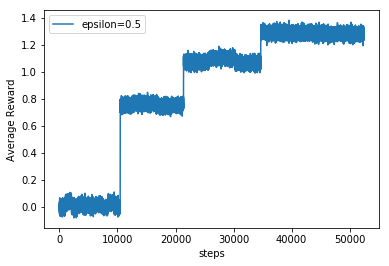

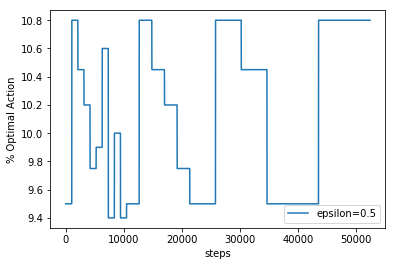

In [15]:
rev_avgs=[]
oa_avgs=[]
for epsilon in [0.5]:
    rewards=[]
    optimalActions=[]
    for i in range(2000):
        medianElimination=MedianElimination(epsilon=epsilon)
        reward,optimalAction=medianElimination.run()
        rewards.append(reward)
        optimalActions.append(optimalAction)
        #print reward
    rewards=np.array(rewards)
    optimalActions=np.array(optimalActions)
    rev_avgs.append(np.mean(rewards,axis=0))
    oa_avgs.append(np.mean(optimalActions,axis=0))
    plt.figure(1)
    plt.plot(range(len(rev_avgs[-1])),rev_avgs[-1],'-',label='epsilon='+str(epsilon))
    plt.figure(2)
    plt.plot(range(len(oa_avgs[-1])),oa_avgs[-1]*100,'-',label='epsilon='+str(epsilon))
    
plt.xlabel('steps')
plt.ylabel('% Optimal Action')
plt.legend()
plt.savefig('./plots/4b.eps',format='eps')

plt.figure(1)
plt.xlabel('steps')
plt.ylabel('Average Reward')
plt.legend()
plt.savefig('./plots/4a.eps',format='eps')
plt.show()